In [1]:
# 1: Import library
#pip install torch torchvision torchaudio numpy librosa sounddevice soundfile matplotlib scipy
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch

# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION
VOWELS = ['Moo', 'Meow', 'Woof', 'Mbee', 'Tweet']
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

## Menyiapkan Dataset untuk Training Model
Dataset yang digunakan akan didapatkan menggunakan rekaman suara anda secara langsung, yang mana anda akan diminta untuk merekam huruf vokal A,I,U,E,dan O sebanyak 15x setiap vokalnya.

In [2]:
# 3: Fungsi Recording untuk Merekam Data
def record_sample(vowel, idx):
    print(f"Recording {vowel} sample {idx + 1}/{5 + 10}...")
    recording = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    filename = os.path.join(DATA_DIR, f"{vowel}_{idx}.wav")
    sf.write(filename, recording, SAMPLE_RATE)
    return filename

# 4: Rekam Data untuk Setiap Vokal
for vowel in VOWELS:
    os.makedirs(os.path.join(DATA_DIR, vowel), exist_ok=True)
    # total 15 per vowel (10 train, 5 test)
    for idx in range(15):
        path = record_sample(vowel, idx)
        os.rename(path, os.path.join(DATA_DIR, vowel, os.path.basename(path)))

Recording Moo sample 1/15...
Recording Moo sample 2/15...
Recording Moo sample 3/15...
Recording Moo sample 4/15...
Recording Moo sample 5/15...
Recording Moo sample 6/15...
Recording Moo sample 7/15...
Recording Moo sample 8/15...
Recording Moo sample 9/15...
Recording Moo sample 10/15...
Recording Moo sample 11/15...
Recording Moo sample 12/15...
Recording Moo sample 13/15...
Recording Moo sample 14/15...
Recording Moo sample 15/15...
Recording Meow sample 1/15...
Recording Meow sample 2/15...
Recording Meow sample 3/15...
Recording Meow sample 4/15...
Recording Meow sample 5/15...
Recording Meow sample 6/15...
Recording Meow sample 7/15...
Recording Meow sample 8/15...
Recording Meow sample 9/15...
Recording Meow sample 10/15...
Recording Meow sample 11/15...
Recording Meow sample 12/15...
Recording Meow sample 13/15...
Recording Meow sample 14/15...
Recording Meow sample 15/15...
Recording Woof sample 1/15...
Recording Woof sample 2/15...
Recording Woof sample 3/15...
Recording Woo

## Pre-processing Dataset dan Ekstraksi Fitur 🔍
Tujuan tahap ini ialah untuk menyiapkan data mentah menjadi fitur siap model. Pre-processing meliputi proses:
- **VAD** (Voice Activity Detection) untuk membuang silent segments  
- **Padding/cropping** agar durasi konsisten  
- **Normalisasi amplitudo**  
- Ekstraksi **MFCC** (40 koefisien), distandarisasi
- Membuat Custom Dataset dan Menyimpan pasangan (MFCC, label)  
- Memisahkan dataset menjadi train (10 data) dan test (5 data)
- Definisi Arsitektur CNN

In [3]:
# 5: Preprocessing Audio Preprocessing dengan VAD dan Feature Extraction
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y


def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc.astype(np.float32)

# 6: Custom Dataset
def gather_files():
    all_files = []
    for label_idx, vowel in enumerate(VOWELS):
        files = sorted(os.listdir(os.path.join(DATA_DIR, vowel)))
        full = [os.path.join(DATA_DIR, vowel, f) for f in files]
        all_files += [(f, label_idx) for f in full]
    return all_files

class VowelDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# 7: Menyiapkan DataLoaders
files = gather_files()
train_list, test_list = [], []
for v_idx, vowel in enumerate(VOWELS):
    fl = [p for p in files if p[1] == v_idx]
    train_list += fl[:10]
    test_list += fl[10:]

train_ds = VowelDataset(train_list)
test_ds = VowelDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# 8: Definisikan CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # compute output size
        dummy = torch.zeros(1,1,40, NUM_SAMPLES//512+1)
        out = self.conv(dummy)
        self.flatten_dim = out.numel()//out.shape[0]
        self.fc = nn.Linear(self.flatten_dim, len(VOWELS))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

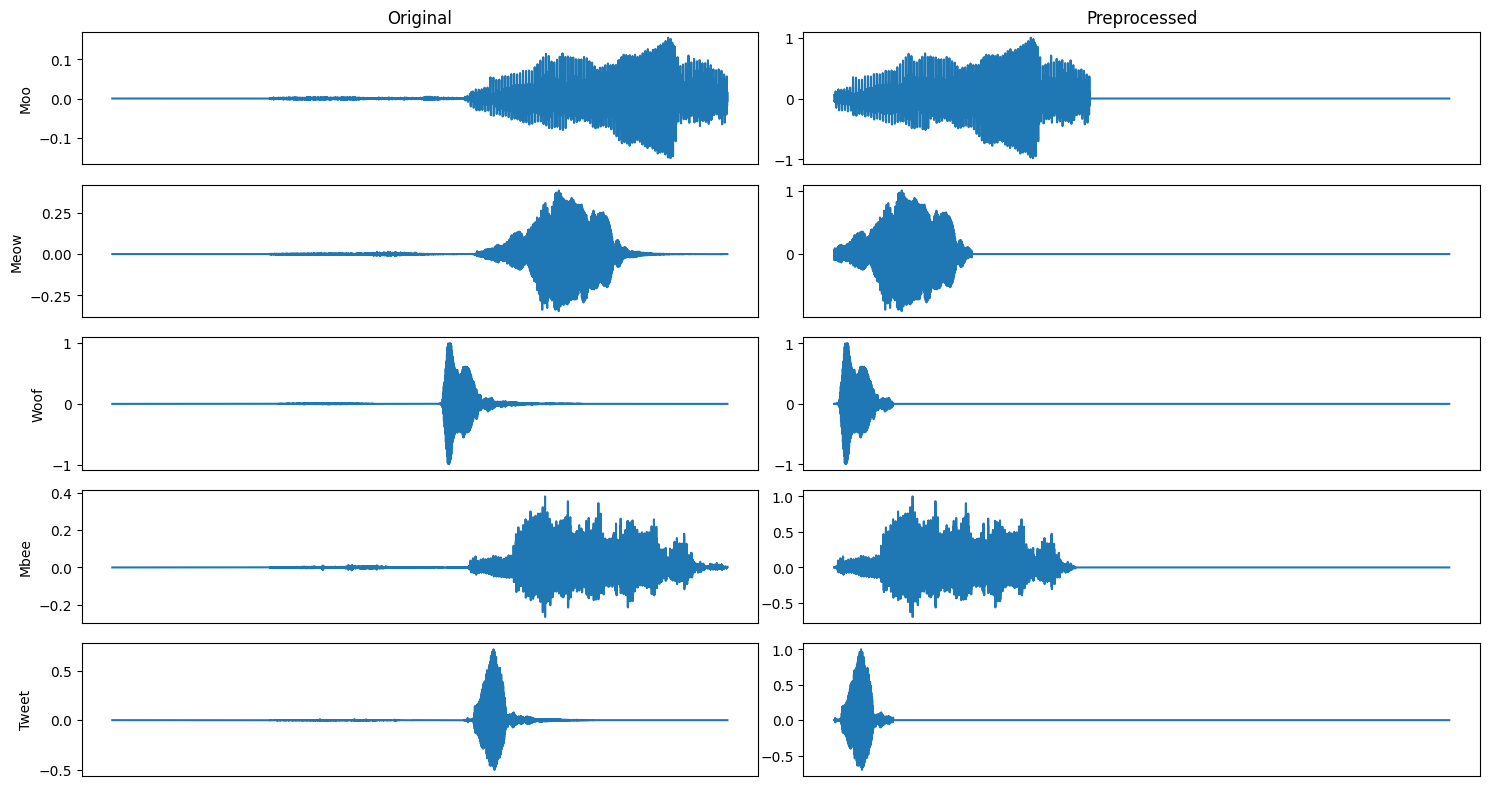

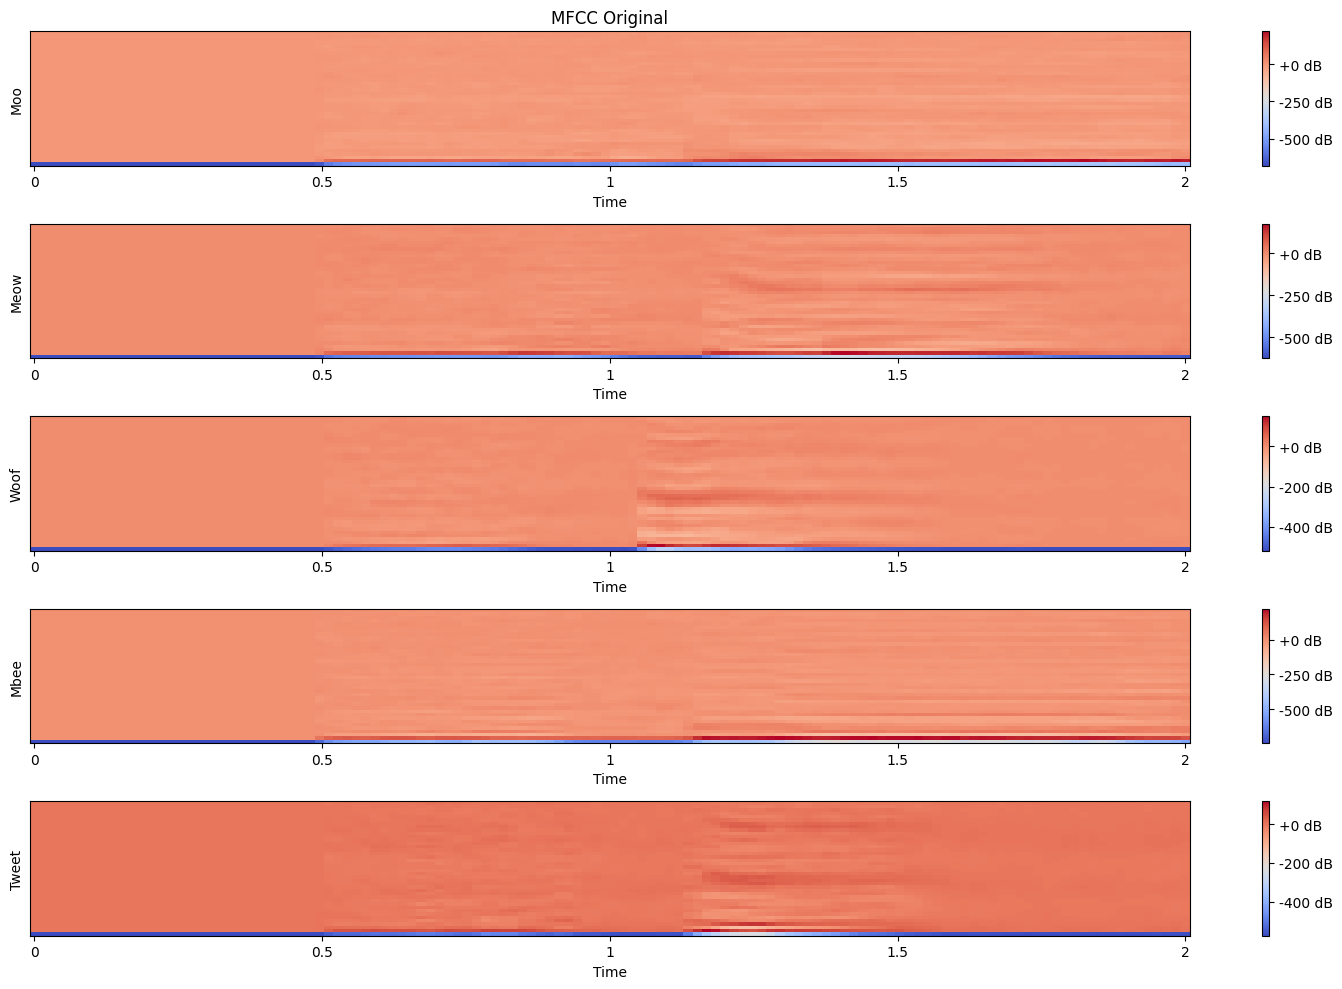

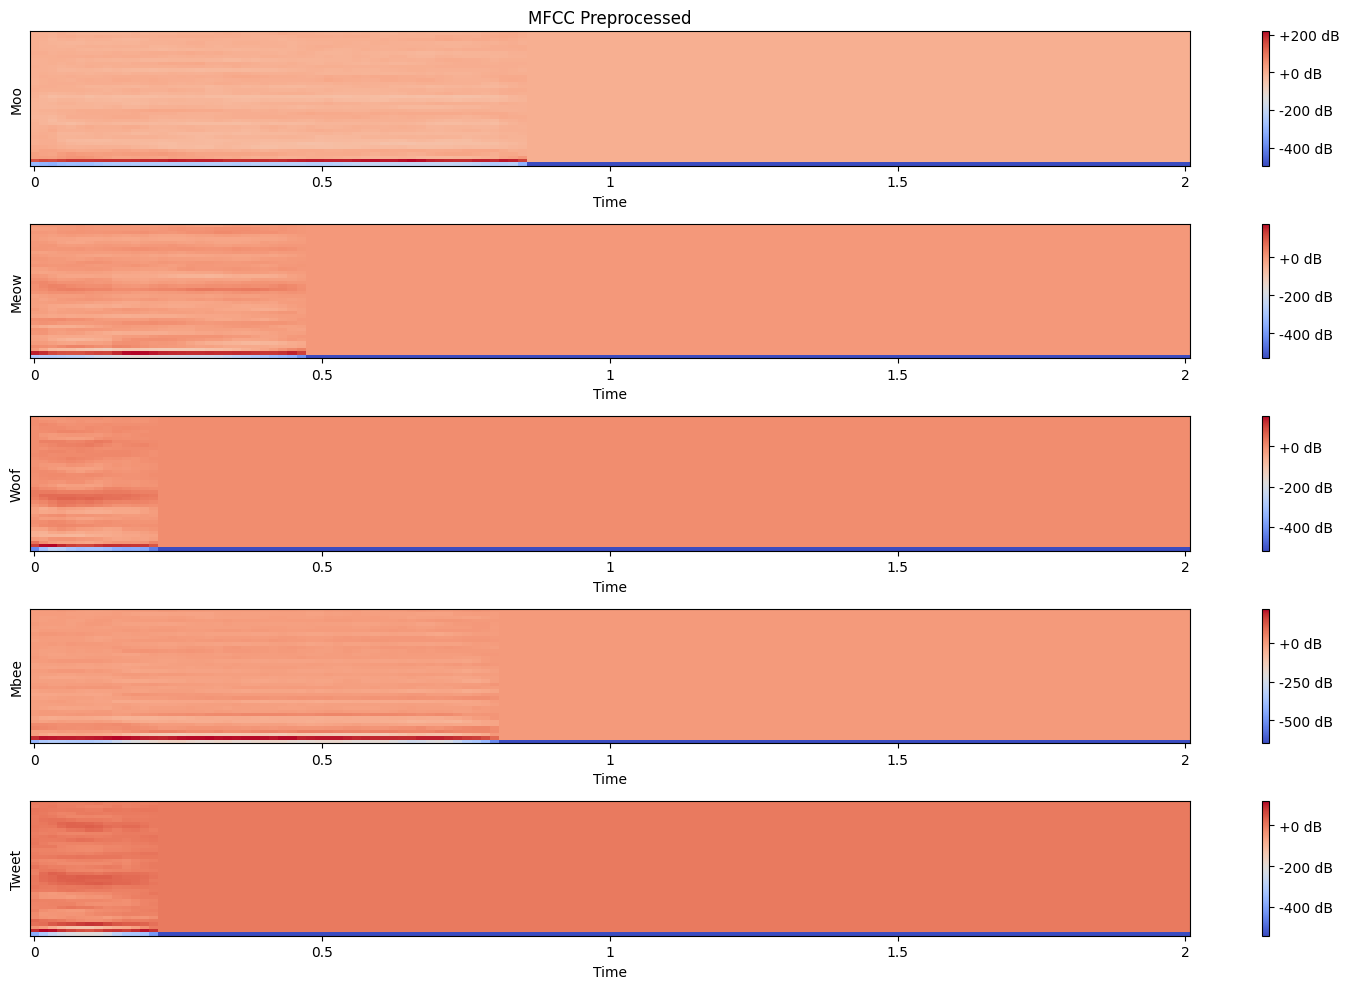

In [4]:
# Perbandingan Bentuk Gelombang dan MFCC tiap Vokal
files_by_vowel = {v: sorted(os.listdir(os.path.join(DATA_DIR, v))) for v in VOWELS}
sample_idx = 0

plt.figure(figsize=(15, 8))
for i, v in enumerate(VOWELS):
    fpath = os.path.join(DATA_DIR, v, files_by_vowel[v][sample_idx])
    y_o, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_p = preprocess_audio(fpath)
    plt.subplot(len(VOWELS), 2, 2*i+1)
    plt.plot(y_o)
    if i == 0: plt.title('Original')
    plt.ylabel(v)
    plt.xticks([])
    plt.subplot(len(VOWELS), 2, 2*i+2)
    plt.plot(y_p)
    if i == 0: plt.title('Preprocessed')
    plt.xticks([])
plt.tight_layout()
plt.show()


for mode, y_func in [('Original', lambda f: librosa.load(f, sr=SAMPLE_RATE)[0][:NUM_SAMPLES]),
                     ('Preprocessed', lambda f: preprocess_audio(f))]:
    plt.figure(figsize=(15, 10))
    for i, v in enumerate(VOWELS):
        fpath = os.path.join(DATA_DIR, v, files_by_vowel[v][sample_idx])
        y = y_func(fpath)
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
        plt.subplot(len(VOWELS), 1, i+1)
        librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel(v)
        if i == 0: plt.title(f'MFCC {mode}')
        else: plt.title('')
    plt.tight_layout()
    plt.show()


### Sumber Referensi Frekuensi: https://biomed.papers.upol.cz/pdfs/bio/2007/02/31.pdf


Detected Formants vs Theoretical Ranges per Vowel:
Moo: Detected F1 = 937.5 Hz [Range: 850-1150 Hz]
    Detected F2 = 1656.2 Hz [Range: 1200-2000 Hz]
Meow: Detected F1 = 750.0 Hz [Range: 700-950 Hz]
    Detected F2 = 1875.0 Hz [Range: 1700-3000 Hz]
Woof: Detected F1 = 437.5 Hz [Range: 300-450 Hz]
    Detected F2 = 3093.8 Hz [Range: 2000-3600 Hz]
Mbee: Detected F1 = 656.2 Hz [Range: 600-800 Hz]
    Detected F2 = 656.2 Hz [Range: 600-1400 Hz]
Tweet: Detected F1 = 375.0 Hz [Range: 100-400 Hz]
    Detected F2 = 468.8 Hz [Range: 400-1200 Hz]


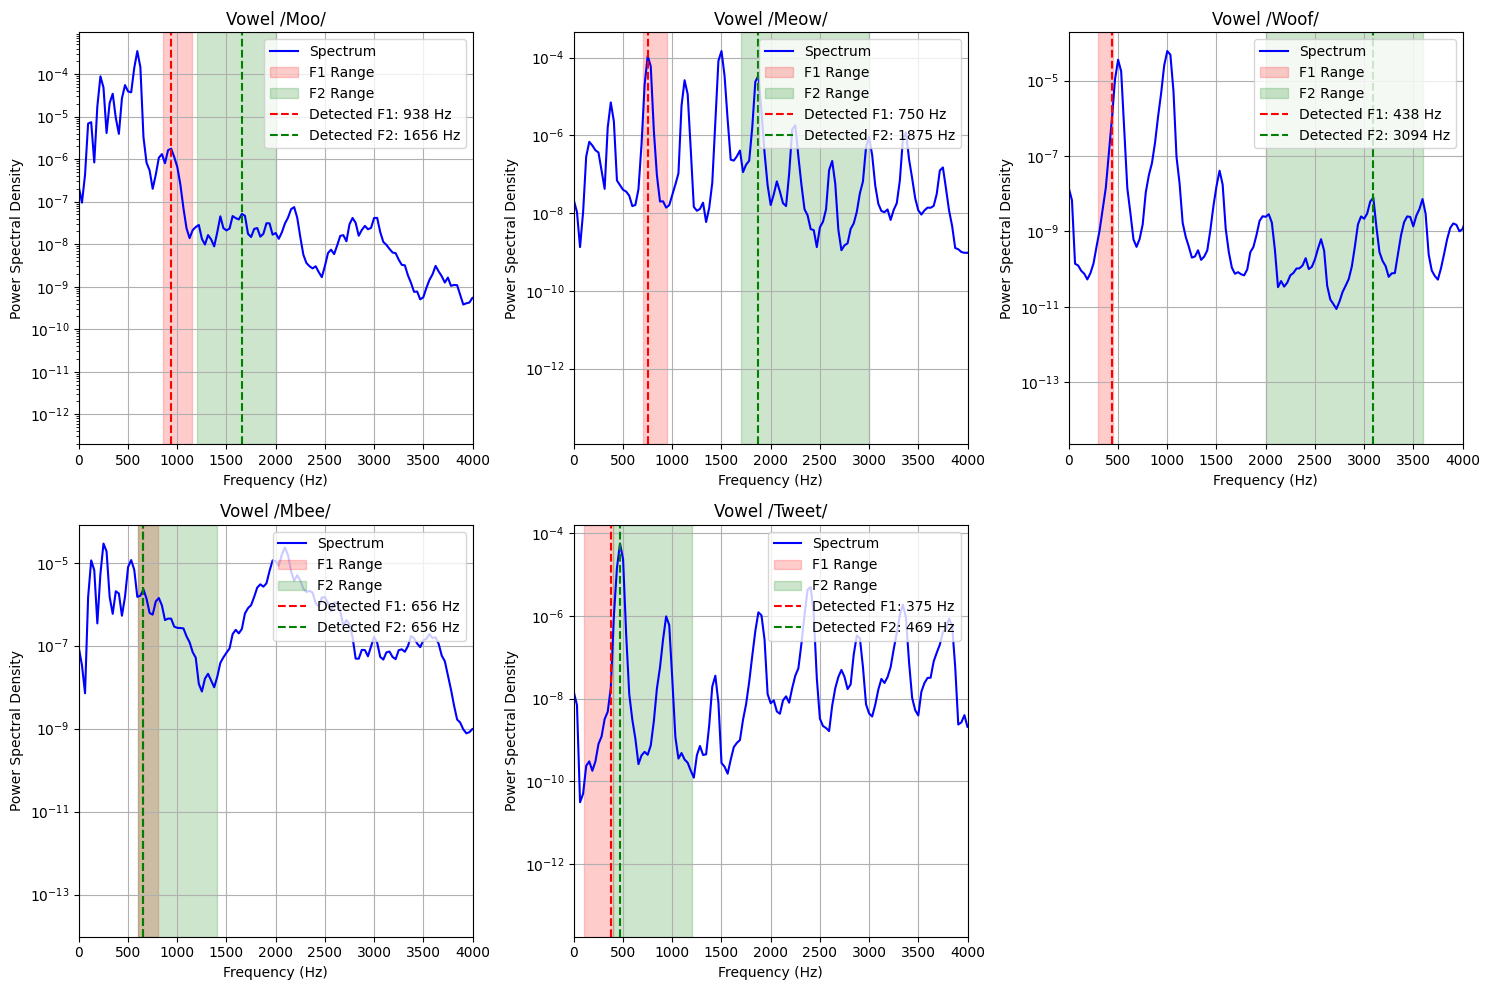

In [7]:


# Define theoretical formant ranges
# ['Moo', 'Meow', 'Woof', 'Mbee', 'Tweet']
vowel_ranges = {
    'Moo': {'F1': (850, 1150), 'F2': (1200, 2000)},
    'Meow': {'F1': (700, 950), 'F2': (1700, 3000)},
    'Woof': {'F1': (300, 450), 'F2': (2000, 3600)},
    'Mbee': {'F1': (600, 800), 'F2': (600, 1400)},
    'Tweet': {'F1': (100, 400), 'F2': (400, 1200)}
}

# Create figure for visualizations
plt.figure(figsize=(15, 10))
plot_idx = 1

print("\nDetected Formants vs Theoretical Ranges per Vowel:")
for v in VOWELS:
    fpath = os.path.join(DATA_DIR, v, files_by_vowel[v][sample_idx])
    y = preprocess_audio(fpath)
    f, Pxx = welch(y, fs=SAMPLE_RATE, nperseg=1024)

    # Find formants within theoretical ranges
    f1_range = vowel_ranges[v]['F1']
    f2_range = vowel_ranges[v]['F2']

    # Mask for formant ranges
    mask_f1 = (f >= f1_range[0]) & (f <= f1_range[1])
    mask_f2 = (f >= f2_range[0]) & (f <= f2_range[1])

    # Detect F1 and F2 (frequency with max power in each range)
    f1_detected = f[mask_f1][np.argmax(Pxx[mask_f1])] if any(mask_f1) else np.nan
    f2_detected = f[mask_f2][np.argmax(Pxx[mask_f2])] if any(mask_f2) else np.nan

    # Create subplot for current vowel
    plt.subplot(2, 3, plot_idx)
    plt.semilogy(f, Pxx, 'b-', label='Spectrum')

    # Highlight theoretical ranges
    plt.axvspan(*f1_range, color='r', alpha=0.2, label='F1 Range')
    plt.axvspan(*f2_range, color='g', alpha=0.2, label='F2 Range')

    # Mark detected formants
    if not np.isnan(f1_detected):
        plt.axvline(f1_detected, color='red', linestyle='--', label=f'Detected F1: {f1_detected:.0f} Hz')
    if not np.isnan(f2_detected):
        plt.axvline(f2_detected, color='green', linestyle='--', label=f'Detected F2: {f2_detected:.0f} Hz')

    plt.title(f'Vowel /{v}/')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.xlim(0, 4000)
    plt.grid(True)
    plt.legend(loc='upper right')

    # Print results
    print(f"{v}: Detected F1 = {f1_detected:.1f} Hz [Range: {f1_range[0]}-{f1_range[1]} Hz]")
    print(f"    Detected F2 = {f2_detected:.1f} Hz [Range: {f2_range[0]}-{f2_range[1]} Hz]")

    plot_idx += 1

plt.tight_layout()
plt.savefig('vowel_formants_comparison.png')
plt.show()

### Kesimpulan Pre-Processing Data
1. Data telah dicleaning dan dinormalisasikan (terlihat dari MFCC dan gelombang suara dimana noise telah berkurang dan ukuran panjang gelombang di normalisasikan)
2. Berdasarkan distribusi frekuensi, dataset yang digunakan telah baik, ditunjukkan pada grafik dimana frekuensi F1 dan F2 tiap vokal pada data berada dalam rentang yang seharusnya sesuai secara teoritikal nya

## **TRAINING MODEL** 📈

Using device: cpu
Epoch 100/100, Loss: 0.0005, Train Acc: 100.00%, Test Acc: 92.00%


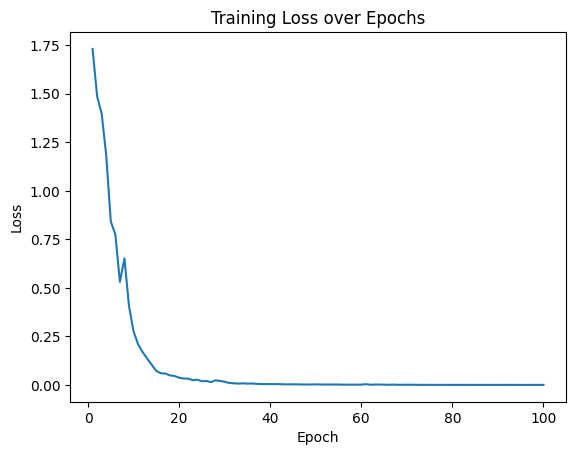

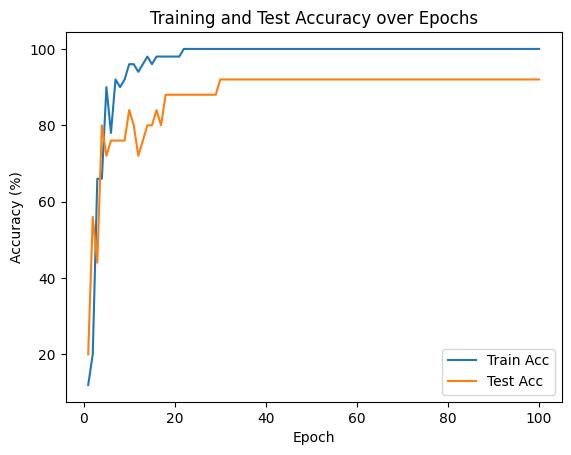

In [8]:
### 9: Training Model
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
# Initialize lists to store metrics
train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)
    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Progress
    sys.stdout.write(
        f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
    )
    sys.stdout.flush()
print()

epochs_range = range(1, epochs + 1)
# Plot loss
plt.figure()
plt.plot(epochs_range, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()


In [9]:
# 10: Evaluasi Kinerja Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}% \n")

# Cell 11: Classification Report
from sklearn.metrics import classification_report
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        all_preds += pred.cpu().tolist()
        all_labels += y.tolist()
print(classification_report(all_labels, all_preds, target_names=VOWELS))

Test Accuracy: 92.00% 

              precision    recall  f1-score   support

         Moo       1.00      1.00      1.00         5
        Meow       1.00      0.60      0.75         5
        Woof       1.00      1.00      1.00         5
        Mbee       1.00      1.00      1.00         5
       Tweet       0.71      1.00      0.83         5

    accuracy                           0.92        25
   macro avg       0.94      0.92      0.92        25
weighted avg       0.94      0.92      0.92        25



In [10]:
# Cell 12: Save Model
torch.save(model.state_dict(), 'vowel_cnn.pth')
print("Model disimpan!")

Model disimpan!


Berdasarkan training serta evaluasi yang telah dilakukan, didapatkan model memiliki performa yang sangat baik yakni mencapai **100%** di semua evaluation metrics. Namun tentunya, mengingat dataset yang digunakan hanya sedikit, penting untuk menjadi pertimbangan pengujian kedepannya dengan menggunakan dataset yang lebih banyak dan variatif 🧮

#### **UJI COBA KLASIFIKASI SUARA VOKAL DENGAN MODEL YANG TELAH DIBUAT** 🚀

In [24]:
# 13: Test Prediction via Recording dengan menampilkan confidence tiap label
import torch.nn.functional as F

def predict_from_record():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN().to(device)
    model.load_state_dict(torch.load('./vowel_cnn.pth', map_location=device))

    print("Ucapkan vokal (A/I/U/E/O)...")
    rec = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    temp_path = 'temp.wav'
    sf.write(temp_path, rec, SAMPLE_RATE)

    feats = extract_features(temp_path)
    x = torch.tensor(feats[np.newaxis, np.newaxis, ...]).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)                     # raw logits
        probs = F.softmax(out, dim=1)[0]   # probability per class

    # tampilkan persentase untuk tiap vowel
    for idx, vowel in enumerate(VOWELS):
        print(f"{vowel}: {probs[idx].item()*100:.2f}%")

    # prediksi tertinggi
    pred_idx = probs.argmax().item()
    print(f"\nVokal Yang Diprediksi: {VOWELS[pred_idx]}")

predict_from_record()


Ucapkan vokal (A/I/U/E/O)...
Moo: 0.00%
Meow: 0.00%
Woof: 0.00%
Mbee: 0.01%
Tweet: 99.99%

Vokal Yang Diprediksi: Tweet
